In [1]:
import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns



from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import BinaryAccuracy,Precision,Recall,AUC,MeanSquaredError,MeanAbsolutePercentageError,RootMeanSquaredError
from tensorflow.keras.losses import BinaryCrossentropy,BinaryFocalCrossentropy,MeanSquaredError,MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

In [2]:
def f1(y_true, y_pred):
    from keras import backend as K
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
df = pd.read_csv('creditcard.csv')

In [45]:
df2 = df.copy().drop(['Time'],axis=1)
df2

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.88,10.07,-9.83,-2.07,-5.36,-2.61,-4.92,7.31,1.91,4.36,...,0.21,0.11,1.01,-0.51,1.44,0.25,0.94,0.82,0.77,0
284803,-0.73,-0.06,2.04,-0.74,0.87,1.06,0.02,0.29,0.58,-0.98,...,0.21,0.92,0.01,-1.02,-0.61,-0.40,0.07,-0.05,24.79,0
284804,1.92,-0.30,-3.25,-0.56,2.63,3.03,-0.30,0.71,0.43,-0.48,...,0.23,0.58,-0.04,0.64,0.27,-0.09,0.00,-0.03,67.88,0
284805,-0.24,0.53,0.70,0.69,-0.38,0.62,-0.69,0.68,0.39,-0.40,...,0.27,0.80,-0.16,0.12,-0.57,0.55,0.11,0.10,10.00,0


In [46]:
train_df, test_df = train_test_split(df2, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

target1 = ['Class']
target2 = ['Amount']
removes = ['Amount','Class']

y1_train = train_df[target1]
y2_train = train_df[target2]
x_train = train_df.copy().drop(removes,axis=1)

y1_test = test_df[target1]
y2_test = test_df[target2]
x_test = test_df.copy().drop(removes,axis=1)

y1_val = val_df[target1]
y2_val = val_df[target2]
x_val = val_df.copy().drop(removes,axis=1)

In [11]:
print("Train Records: {} Percent: {:.2%} Positive Labels: {} Percent: {:.4%}".format(len(y1_train),len(y1_train)/len(df2),np.count_nonzero(y1_train),np.count_nonzero(y1_train)/len(y1_train)))
print("Val Records: {} Percent: {:.2%} Positive Labels: {} Percent: {:.4%}".format(len(y1_val),len(y1_val)/len(df2),np.count_nonzero(y1_val),np.count_nonzero(y1_val)/len(y1_val)))
print("Test Records: {}  Percent: {:.2%} Positive Labels: {} Percent: {:.4%}".format(len(y1_test),len(y1_test)/len(df2),np.count_nonzero(y1_test),np.count_nonzero(y1_test)/len(y1_test)))

Train Records: 182276 Percent: 64.00% Positive Labels: 322 Percent: 0.1767%
Val Records: 45569 Percent: 16.00% Positive Labels: 80 Percent: 0.1756%
Test Records: 56962  Percent: 20.00% Positive Labels: 90 Percent: 0.1580%


In [12]:
early_stopping = EarlyStopping(monitor='val_loss',verbose=1,patience=10,restore_best_weights=True)
batch_size = 2048
epochs = 100

In [81]:
def bias_builder(arr):
    return np.log(np.count_nonzero(arr)/len(arr))

def build_binary_model():
    input_layer = Input(shape=(x_train.shape[-1],), name="input_layer")

    first_dense = Dense(units=28,activation='elu',name="first_dense")(input_layer)
    first_dropout = Dropout(.5)(first_dense)
    last_layer = Dense(units=16,activation='elu',name="last_dense")(first_dense)
    last_dropout = Dropout(.5)(last_layer)

    binary_output = Dense(units=1,activation='sigmoid',name='binary_output',bias_initializer=Constant(bias_builder(y1_train)))(last_layer)

    model = Model(inputs=input_layer,outputs=binary_output,name="binary_model")

    return model

In [82]:
binary_model = build_binary_model()
binary_model.summary()

Model: "binary_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28)]              0         
                                                                 
 first_dense (Dense)         (None, 28)                812       
                                                                 
 last_dense (Dense)          (None, 16)                464       
                                                                 
 binary_output (Dense)       (None, 1)                 17        
                                                                 
Total params: 1,293
Trainable params: 1,293
Non-trainable params: 0
_________________________________________________________________


In [83]:
binary_model.compile(optimizer=SGD(learning_rate=.01),loss=BinaryCrossentropy(),metrics=[BinaryAccuracy(name='accuracy'),f1,AUC(name='auc')])

binary_history = binary_model.fit(x_train,y1_train,batch_size=batch_size,epochs=epochs,callbacks=[early_stopping],validation_data=(x_val, y1_val))

Epoch 1/100
90/90 [==============================] - 2s 8ms/step - loss: 0.0121 - accuracy: 0.9976 - f1: 0.0922 - auc: 0.8624 - val_loss: 0.0114 - val_accuracy: 0.9980 - val_f1: 0.1572 - val_auc: 0.8577
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0108 - accuracy: 0.9979 - f1: 0.1825 - auc: 0.8831 - val_loss: 0.0104 - val_accuracy: 0.9982 - val_f1: 0.2263 - val_auc: 0.8688
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0098 - accuracy: 0.9981 - f1: 0.2467 - auc: 0.8938 - val_loss: 0.0097 - val_accuracy: 0.9983 - val_f1: 0.2593 - val_auc: 0.8729
Epoch 4/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0092 - accuracy: 0.9982 - f1: 0.2678 - auc: 0.8983 - val_loss: 0.0092 - val_accuracy: 0.9984 - val_f1: 0.3059 - val_auc: 0.8747
Epoch 5/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0086 - accuracy: 0.9983 - f1: 0.2796 - auc: 0.9020 - val_loss: 0.0088 - val_accuracy: 0.9984 - val_f1: 0.3233 - v

In [75]:
def plot_binary_metrics(history):
  metrics = ['loss', 'accuracy', 'f1', 'auc']
  
  fig,axs = plt.subplots(2,2,figsize=(16,12))
  axs = axs.ravel()

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    axs[n].plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    axs[n].plot(history.epoch, history.history['val_'+metric],color=colors[0], linestyle="--", label='Val')
    axs[n].set_xlabel('Epoch')
    axs[n].set_ylabel(name)

    axs[n].legend()
  plt.show()

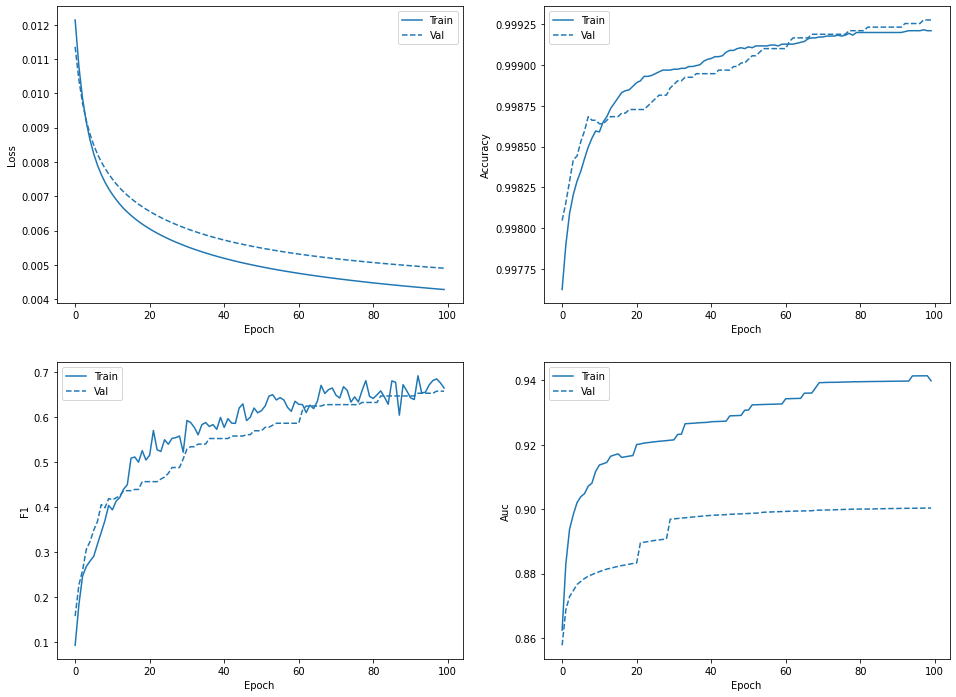

In [84]:
plot_binary_metrics(binary_history)

In [85]:
def build_regression_model():
    input_layer = Input(shape=(x_train.shape[-1],), name="input_layer")

    first_dense = Dense(units=28,activation='elu',name="first_dense")(input_layer)
    first_dropout = Dropout(.5)(first_dense)
    last_layer = Dense(units=16,activation='elu',name="last_dense")(first_dense)
    last_dropout = Dropout(.5)(last_layer)

    regression_output = Dense(units=1,name='regression_output')(last_layer)

    model = Model(inputs=input_layer,outputs=regression_output,name="regression_model")

    return model

In [86]:
x_train.shape[-1]

28

In [87]:
regression_model = build_regression_model()

regression_model.summary()

Model: "regression_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28)]              0         
                                                                 
 first_dense (Dense)         (None, 28)                812       
                                                                 
 last_dense (Dense)          (None, 16)                464       
                                                                 
 regression_output (Dense)   (None, 1)                 17        
                                                                 
Total params: 1,293
Trainable params: 1,293
Non-trainable params: 0
_________________________________________________________________


In [88]:
regression_model.compile(optimizer=SGD(learning_rate=.01),loss=MeanSquaredLogarithmicError(),metrics=[MeanSquaredError(name='mse'),RootMeanSquaredError(name='rmse'),MeanAbsolutePercentageError(name='mape')])

regression_history = regression_model.fit(x_train,y2_train,batch_size=batch_size,epochs=epochs,callbacks=[early_stopping],validation_data=(x_val, y2_val))

Epoch 1/100
90/90 [==============================] - 1s 6ms/step - loss: 5.8851 - mse: 65434.6680 - rmse: 257.2292 - mape: 23760540.0000 - val_loss: 3.3235 - val_mse: 85819.1016 - val_rmse: 296.1458 - val_mape: 42429284.0000
Epoch 2/100
90/90 [==============================] - 0s 4ms/step - loss: 2.7454 - mse: 63026.3555 - rmse: 252.0970 - mape: 63446332.0000 - val_loss: 2.3408 - val_mse: 82495.3984 - val_rmse: 290.3797 - val_mape: 74612064.0000
Epoch 3/100
90/90 [==============================] - 0s 4ms/step - loss: 2.1656 - mse: 60265.7891 - rmse: 246.7871 - mape: 91793056.0000 - val_loss: 2.0073 - val_mse: 79371.1719 - val_rmse: 284.8421 - val_mape: 92459072.0000
Epoch 4/100
90/90 [==============================] - 0s 4ms/step - loss: 1.9152 - mse: 57857.6992 - rmse: 241.8739 - mape: 106358176.0000 - val_loss: 1.8154 - val_mse: 76397.8203 - val_rmse: 279.4612 - val_mape: 99710560.0000
Epoch 5/100
90/90 [==============================] - 0s 4ms/step - loss: 1.7509 - mse: 55655.4492 -

In [89]:
def plot_regression_metrics(history):
  metrics = ['loss', 'mse', 'rmse', 'mape']
  
  fig,axs = plt.subplots(2,2,figsize=(24,18))
  axs = axs.ravel()

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    axs[n].plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    axs[n].plot(history.epoch, history.history['val_'+metric],color=colors[0], linestyle="--", label='Val')
    axs[n].set_xlabel('Epoch')
    axs[n].set_ylabel(name)

    axs[n].legend()

  plt.show()

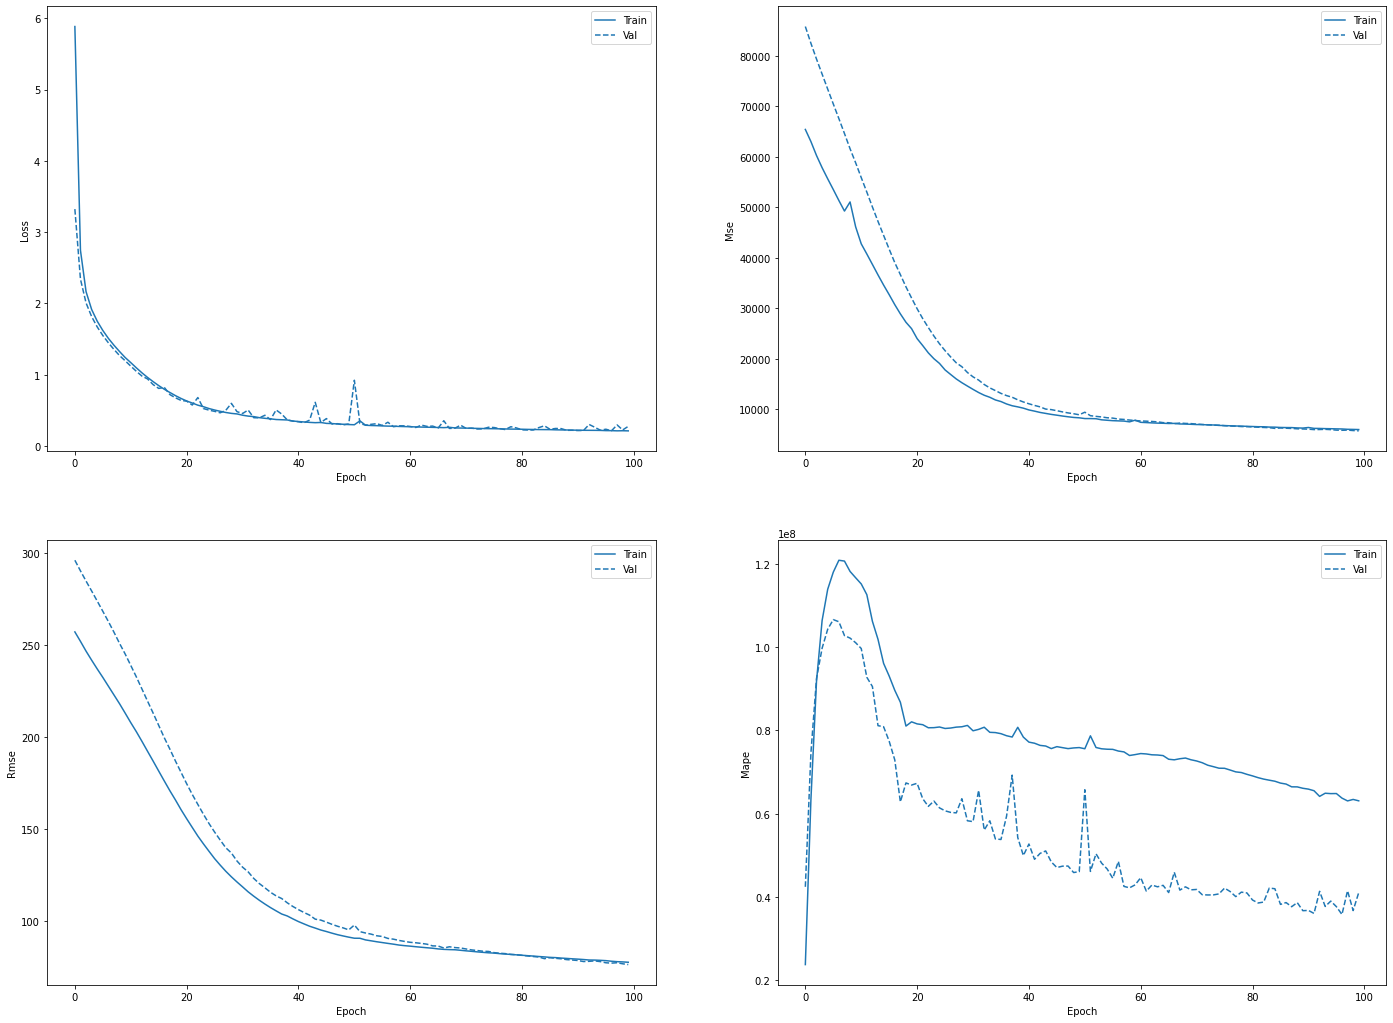

In [90]:
plot_regression_metrics(regression_history)

In [91]:
y2hat_test  =regression_model.predict(x_test, verbose=0)

In [94]:
test_results = y2_test.copy()
test_results['Class'] = y1_test
test_results['Prediction'] = y2hat_test
test_results['Difference'] = test_results['Amount']-test_results['Prediction']
test_results['Increase'] = test_results['Difference']/test_results['Prediction']
test_results.sort_values(['Difference'],ascending=[True]).head(10)

,Amount,Class,Prediction,Difference,Increase
206255,1676.60,0,8266.91,-6590.31,-0.80
230944,1350.00,0,4572.45,-3222.45,-0.70
131480,1593.37,0,4798.23,-3204.86,-0.67
262378,2074.69,0,4804.36,-2729.67,-0.57
219257,3502.11,0,6158.24,-2656.13,-0.43
70031,9.00,0,2544.16,-2535.16,-1.00
212822,0.76,0,1987.62,-1986.86,-1.00
98675,3307.14,0,5131.90,-1824.76,-0.36
86492,720.00,0,2499.99,-1779.99,-0.71
236429,152.00,0,1842.48,-1690.48,-0.92


In [95]:
def build_multitask_model():
    input_layer = Input(shape=(x_train.shape[-1],), name="input_layer")

    first_dense = Dense(units=28,activation='elu',name="first_dense")(input_layer)
    first_dropout = Dropout(.5)(first_dense)
    last_layer = Dense(units=16,activation='elu',name="last_dense")(first_dense)
    last_dropout = Dropout(.5)(last_layer)

    binary_output = Dense(units=1,activation='sigmoid',name='binary_output',bias_initializer=Constant(bias_builder(y1_train)))(last_layer)
    regression_output = Dense(units=1,name='regression_output')(last_layer)

    model = Model(inputs=input_layer,outputs=[binary_output,regression_output],name="multitask_model")

    return model

In [99]:
multitask_model = build_multitask_model()

multitask_model.summary()

Model: "multitask_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 28)]         0           []                               
                                                                                                  
 first_dense (Dense)            (None, 28)           812         ['input_layer[0][0]']            
                                                                                                  
 last_dense (Dense)             (None, 16)           464         ['first_dense[0][0]']            
                                                                                                  
 binary_output (Dense)          (None, 1)            17          ['last_dense[0][0]']             
                                                                                    

In [100]:
multitask_model.compile(
    optimizer=SGD(learning_rate=.01),
    loss={
        "binary_output":BinaryCrossentropy(),
        "regression_output":MeanSquaredLogarithmicError()
        },
    metrics={
        "binary_output":[f1,AUC(name='auc')],
        "regression_output":[MeanSquaredError(name='mse'),MeanAbsolutePercentageError(name='mape')]
        }
    )

multitask_history = multitask_model.fit(x_train,[y1_train,y2_train],batch_size=batch_size,epochs=epochs,callbacks=[early_stopping],validation_data=(x_val, [y1_val,y2_val]))

Epoch 1/100
90/90 [==============================] - 2s 10ms/step - loss: 5.7803 - binary_output_loss: 0.0297 - regression_output_loss: 5.7506 - binary_output_f1: 0.0000e+00 - binary_output_auc: 0.2437 - regression_output_mse: 68308.1094 - regression_output_rmse: 257.8425 - regression_output_mape: 30690494.0000 - val_loss: 3.3903 - val_binary_output_loss: 0.0362 - val_regression_output_loss: 3.3542 - val_binary_output_f1: 0.0000e+00 - val_binary_output_auc: 0.1977 - val_regression_output_mse: 86220.6875 - val_regression_output_rmse: 296.8413 - val_regression_output_mape: 51877976.0000
Epoch 2/100
90/90 [==============================] - 1s 6ms/step - loss: 2.8264 - binary_output_loss: 0.0346 - regression_output_loss: 2.7918 - binary_output_f1: 0.0000e+00 - binary_output_auc: 0.1809 - regression_output_mse: 63175.2773 - regression_output_rmse: 252.7127 - regression_output_mape: 72746824.0000 - val_loss: 2.4457 - val_binary_output_loss: 0.0320 - val_regression_output_loss: 2.4137 - val_b

In [105]:
def plot_multitask_metrics(history):
  metrics = ['binary_output_loss','binary_output_f1','binary_output_auc','regression_output_loss', 'regression_output_mse', 'regression_output_mape']
  
  fig,axs = plt.subplots(2,3,figsize=(30,18))
  axs = axs.ravel()

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    axs[n].plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    axs[n].plot(history.epoch, history.history['val_'+metric],color=colors[0], linestyle="--", label='Val')
    axs[n].set_xlabel('Epoch')
    axs[n].set_ylabel(name)

    axs[n].legend()

  plt.show()

In [ ]:
plot_multitask_metrics

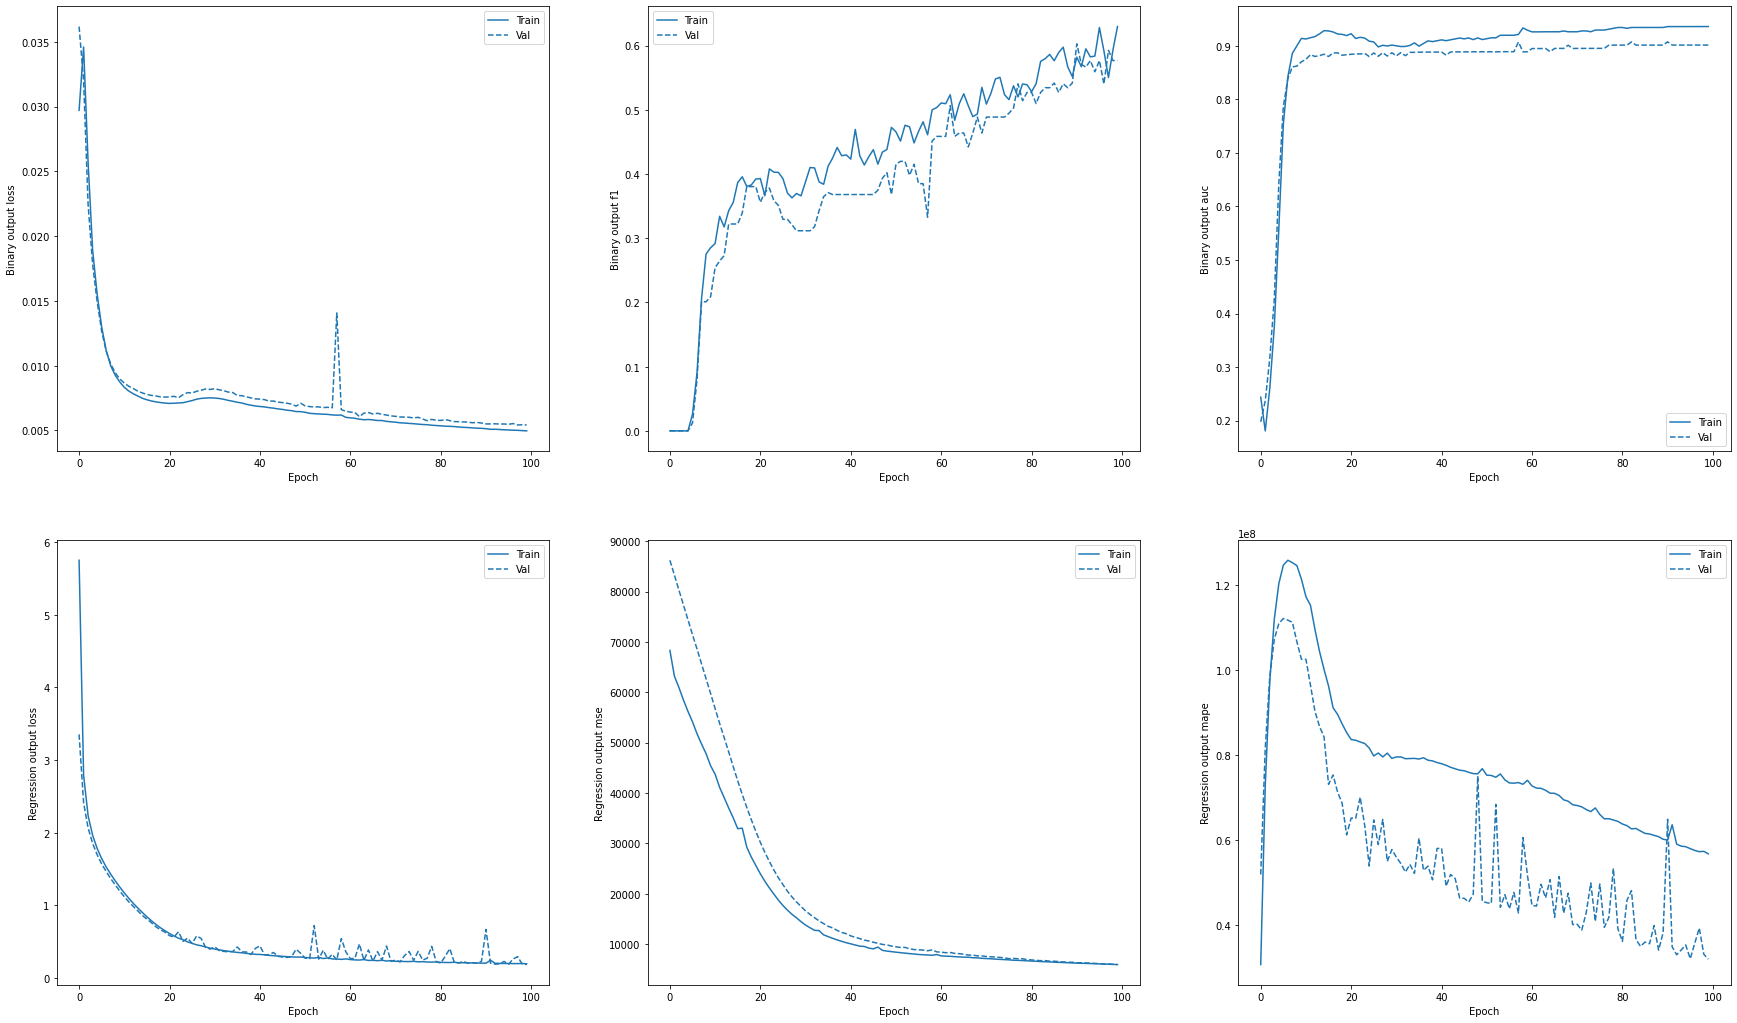

In [106]:
plot_multitask_metrics(multitask_history)

In [108]:
yhat1_test,yhat2_test = multitask_model.predict(x_test, verbose=0)

In [112]:
comb_test_results = y1_test.copy()
comb_test_results['Amount'] = y2_test
comb_test_results['Class Prediction'] = yhat1_test
comb_test_results['Amount Prediction'] = yhat2_test
comb_test_results['Difference'] = comb_test_results['Amount']-comb_test_results['Amount Prediction']
comb_test_results['Increase'] = comb_test_results['Difference']/comb_test_results['Amount Prediction']
comb_test_results.sort_values(['Difference'],ascending=[False]).head(10)

,Class,Amount,Class Prediction,Amount Prediction,Difference,Increase
227921,0,10000.00,0.00,6149.69,3850.31,0.63
245474,0,8787.00,0.00,6518.23,2268.77,0.35
228723,0,7367.00,0.00,5474.25,1892.75,0.35
118920,0,3790.39,0.00,1987.03,1803.36,0.91
40207,0,2849.94,0.00,1594.79,1255.15,0.79
44947,0,4276.82,0.00,3043.93,1232.89,0.41
181964,0,4833.00,0.00,3617.30,1215.70,0.34
211322,0,4675.00,0.00,3498.90,1176.10,0.34
118710,0,4642.20,0.00,3475.89,1166.31,0.34
33756,0,4476.72,0.00,3351.81,1124.91,0.34


In [111]:
comb_test_results.sort_values(['Class Prediction'],ascending=[False]).head(10)

,Class,Amount,Class Prediction,Amount Prediction,Difference,Increase
10630,1,766.36,1.00,458.80,307.56,0.67
150662,1,316.06,1.00,75.13,240.93,3.21
150687,1,1.00,1.00,97.16,-96.16,-0.99
141260,1,512.25,1.00,334.71,177.54,0.53
11343,1,1.00,1.00,358.72,-357.72,-1.00
10891,1,188.78,1.00,523.35,-334.57,-0.64
12922,0,89.99,1.00,127.89,-37.90,-0.30
42856,1,173.07,1.00,308.71,-135.64,-0.44
150678,1,30.31,1.00,372.41,-342.10,-0.92
153823,1,2.28,1.00,85.58,-83.30,-0.97


In [124]:
comb_test_results.set_index(['Class'])[['Difference']].stack().groupby(level=0).describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,56868.00,7.73,71.61,-6231.10,0.16,1.97,7.37,3850.31
1,94.00,-22.49,147.99,-523.28,-46.45,0.07,36.66,373.58
